In [24]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="darkgrid")
sns.set_palette("husl")

In [25]:
# Load JSON and flatten all iterations into one DataFrame
with open("cavity_design_log.json", "r") as f:
    data = json.load(f)

rows = []
for key, cfg in data.items():
    for h in cfg["design_history"]:
        rows.append({
            "Q": h["result"]["Q"],
            "V": h["result"]["V"],
            "Q/V": h["result"]["qv_ratio"],
            "resonance_nm": h["result"].get("resonance_nm", 0),
            "period": round(h["params"]["period_nm"]),
            "rx": round(h["params"]["hole_rx_nm"]),
            "ry": round(h["params"]["hole_ry_nm"]),
            "taper": h["params"]["num_taper_holes"],
            "min_a%": h["params"]["min_a_percent"],
        })

df = pd.DataFrame(rows).sort_values("Q", ascending=False).reset_index(drop=True)
df.index = df.index + 1  # 1-based ranking
df.index.name = "#"

target_wl = 737  # nm

print(f"Total simulations: {len(df)}")
print(f"Target wavelength: {target_wl} nm\n")
df

Total simulations: 38
Target wavelength: 737 nm



,Q,V,Q/V,resonance_nm,period,rx,ry,taper,min_a%
#,,,,,,,,,
1,305049,1.606,189969,763.87,315,90,120,12,87
2,114701,1.737,66048,721.30,295,90,120,12,87
3,102091,2.448,41709,732.31,300,90,120,12,87
4,21113,2.018,10463,726.32,290,80,120,12,87
5,20599,2.291,8990,710.00,276,70,120,12,87
6,19591,2.369,8270,736.74,295,80,120,12,87
7,18001,2.430,7409,757.10,305,80,120,12,87
8,17979,2.212,8128,721.29,276,60,120,12,87
9,15641,2.089,7486,729.75,276,50,120,12,87


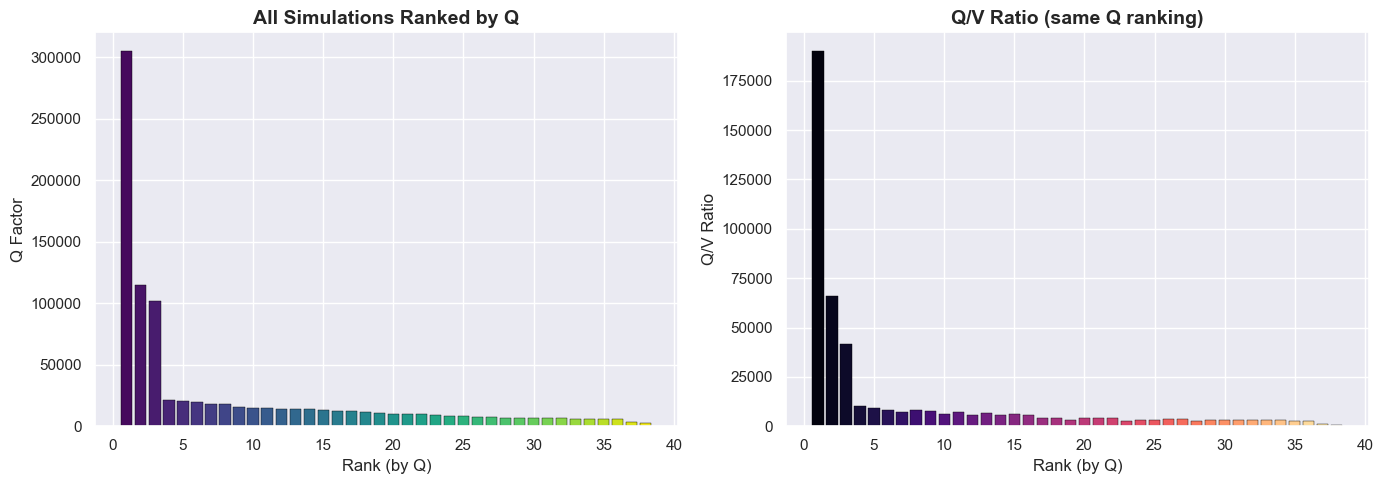

In [26]:
# -- Q and Q/V vs global rank --
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(df.index, df["Q"], color=sns.color_palette("viridis", len(df)), edgecolor="black", linewidth=0.3)
axes[0].set_xlabel("Rank (by Q)", fontsize=12)
axes[0].set_ylabel("Q Factor", fontsize=12)
axes[0].set_title("All Simulations Ranked by Q", fontsize=14, fontweight="bold")

axes[1].bar(df.index, df["Q/V"], color=sns.color_palette("magma", len(df)), edgecolor="black", linewidth=0.3)
axes[1].set_xlabel("Rank (by Q)", fontsize=12)
axes[1].set_ylabel("Q/V Ratio", fontsize=12)
axes[1].set_title("Q/V Ratio (same Q ranking)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

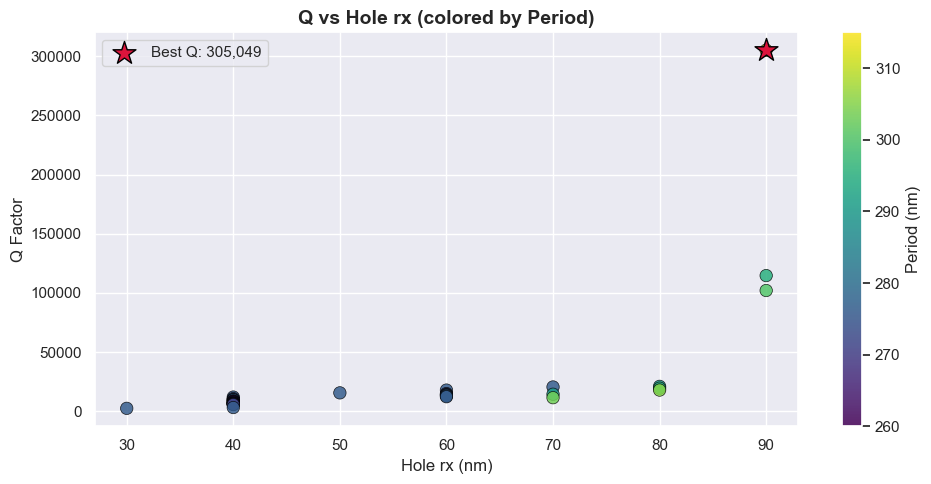

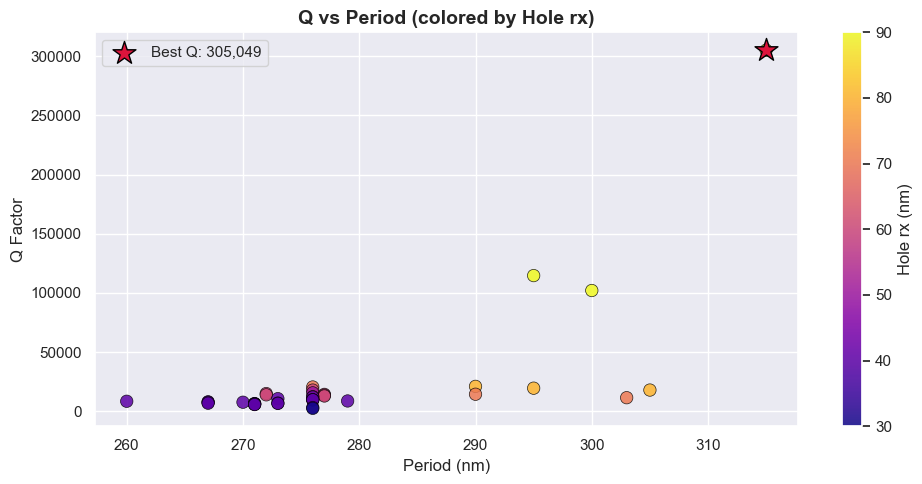

In [27]:
# -- Q vs hole_rx scatter (colored by period) --
fig, ax = plt.subplots(figsize=(10, 5))
sc = ax.scatter(df["rx"], df["Q"], c=df["period"], cmap="viridis",
                s=80, edgecolors="black", linewidths=0.5, alpha=0.85)
plt.colorbar(sc, ax=ax, label="Period (nm)")
best = df.iloc[0]
ax.scatter([best["rx"]], [best["Q"]], color="crimson", s=300, zorder=5,
           marker="*", edgecolors="black", linewidths=1, label=f"Best Q: {best['Q']:,.0f}")
ax.set_xlabel("Hole rx (nm)", fontsize=12)
ax.set_ylabel("Q Factor", fontsize=12)
ax.set_title("Q vs Hole rx (colored by Period)", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# -- Q vs Period scatter (colored by rx) --
fig, ax = plt.subplots(figsize=(10, 5))
sc = ax.scatter(df["period"], df["Q"], c=df["rx"], cmap="plasma",
                s=80, edgecolors="black", linewidths=0.5, alpha=0.85)
plt.colorbar(sc, ax=ax, label="Hole rx (nm)")
ax.scatter([best["period"]], [best["Q"]], color="crimson", s=300, zorder=5,
           marker="*", edgecolors="black", linewidths=1, label=f"Best Q: {best['Q']:,.0f}")
ax.set_xlabel("Period (nm)", fontsize=12)
ax.set_ylabel("Q Factor", fontsize=12)
ax.set_title("Q vs Period (colored by Hole rx)", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

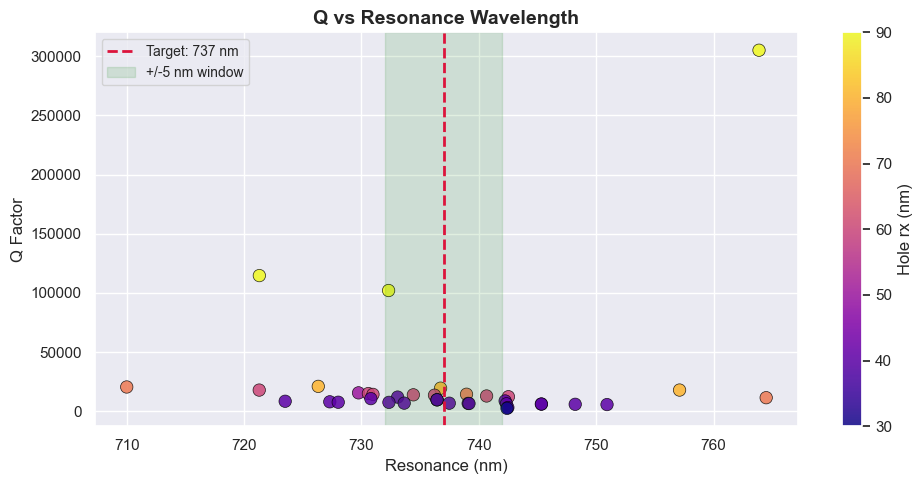

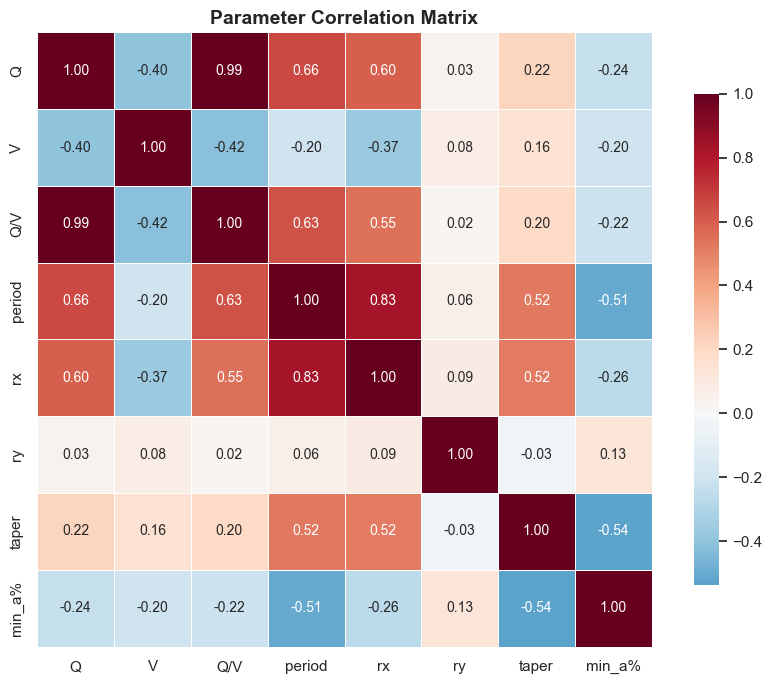

In [28]:
# -- Resonance wavelength vs Q --
fig, ax = plt.subplots(figsize=(10, 5))
sc = ax.scatter(df["resonance_nm"], df["Q"], c=df["rx"], cmap="plasma",
                s=80, edgecolors="black", linewidths=0.5, alpha=0.85)
plt.colorbar(sc, ax=ax, label="Hole rx (nm)")
ax.axvline(x=target_wl, color="crimson", linestyle="--", linewidth=2, label=f"Target: {target_wl} nm")
ax.axvspan(target_wl - 5, target_wl + 5, alpha=0.12, color="green", label="+/-5 nm window")
ax.set_xlabel("Resonance (nm)", fontsize=12)
ax.set_ylabel("Q Factor", fontsize=12)
ax.set_title("Q vs Resonance Wavelength", fontsize=14, fontweight="bold")
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# -- Correlation heatmap --
fig, ax = plt.subplots(figsize=(9, 7))
corr_cols = ["Q", "V", "Q/V", "period", "rx", "ry", "taper", "min_a%"]
sns.heatmap(df[corr_cols].corr(), annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 10})
ax.set_title("Parameter Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [29]:
# -- Top 3 best designs --
print("TOP 3 DESIGNS BY Q")
print("=" * 80)
for i in range(min(3, len(df))):
    r = df.iloc[i]
    print(f"  #{i+1}  Q={r['Q']:>10,.0f}  V={r['V']:.3f}  Q/V={r['Q/V']:>10,.0f}  "
          f"res={r['resonance_nm']:.1f}nm  p={r['period']}  rx={r['rx']}  ry={r['ry']}  "
          f"taper={r['taper']}  min_a={r['min_a%']}%")
print("=" * 80)

# Detuning from target
for i in range(min(3, len(df))):
    r = df.iloc[i]
    delta = r["resonance_nm"] - target_wl
    print(f"  #{i+1} detuning from {target_wl}nm target: {delta:+.1f} nm")

TOP 3 DESIGNS BY Q
  #1  Q=   305,049  V=1.606  Q/V=   189,969  res=763.9nm  p=315.0  rx=90.0  ry=120.0  taper=12.0  min_a=87.0%
  #2  Q=   114,701  V=1.737  Q/V=    66,048  res=721.3nm  p=295.0  rx=90.0  ry=120.0  taper=12.0  min_a=87.0%
  #3  Q=   102,091  V=2.448  Q/V=    41,709  res=732.3nm  p=300.0  rx=90.0  ry=120.0  taper=12.0  min_a=87.0%
  #1 detuning from 737nm target: +26.9 nm
  #2 detuning from 737nm target: -15.7 nm
  #3 detuning from 737nm target: -4.7 nm


In [30]:
import anthropic

client = anthropic.Anthropic()

message = client.messages.create(
    model="MiniMax-M2.1",
    max_tokens=1000,
    system="You are a helpful assistant.",
    messages=[
        {"role": "user", "content": [{"type": "text", "text": "Hi, how are you?"}]}
    ],
)

for block in message.content:
    if block.type == "thinking":
        print(f"Thinking:\n{block.thinking}\n")
    elif block.type == "text":
        print(f"Text:\n{block.text}\n")

NotFoundError: Error code: 404 - {'type': 'error', 'error': {'type': 'not_found_error', 'message': 'model: MiniMax-M2.1'}, 'request_id': 'req_011CXrgpNMnCAN3z8AHx7wKV'}